In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import cv2
import keras

from PIL import Image 

### Unique Files for further Testing
C:\Users\atcut\Documents\ML_Proj\Digit Classification\puzzles\_4_3941682.jpeg

C:\Users\atcut\Documents\ML_Proj\Digit Classification\puzzles\_0_926439.jpeg


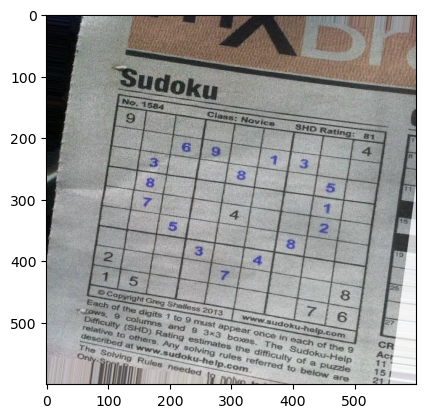

In [2]:
# file = r"C:\Users\atcut\Documents\ML_Proj\Digit Classification\puzzles"
# file = file + '\\' +random.choice(os.listdir(file))
file = r"C:\Users\atcut\Documents\ML_Proj\Digit Classification\puzzles\_0_926439.jpeg"
print(file)

img = cv2.imread(file)
plt.imshow(img)
plt.show()

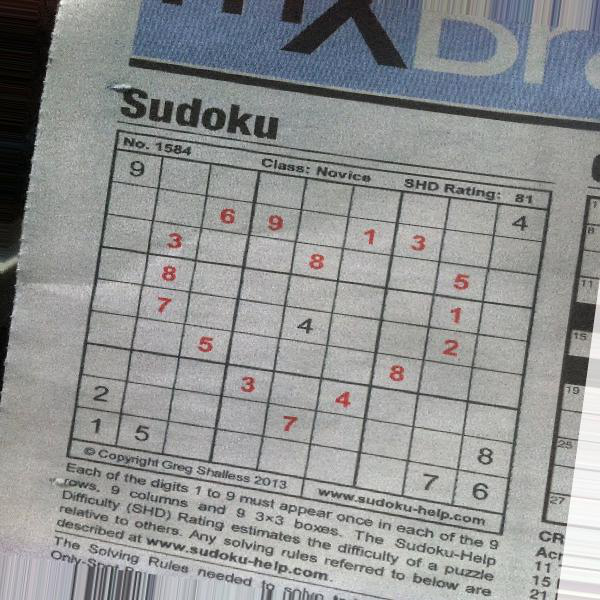

In [3]:
temp = Image.open(file)
display(temp)


### Image Preprocessing 
Removing extraneous noise and resizing images

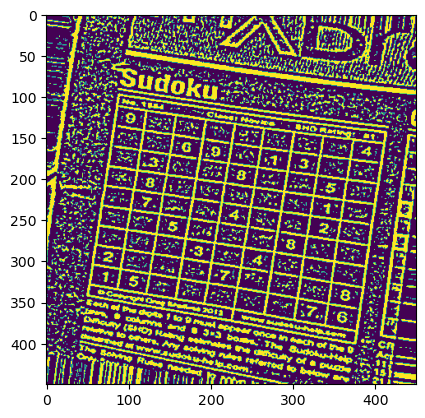

In [4]:
def prep(img):
    size = cv2.resize(img, (450,450))
    gray = cv2.cvtColor(size, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) #remember (3,3) is kernel
    new_img = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    return size, new_img

img, test = prep(img)
plt.imshow(test)
plt.show()

### Detecting Contours

Notes: Low Camera Angles of Images may render the Puzzle's border to be difficult to detect accurately.

It may omit individual subsections due to lack of border line clarity.

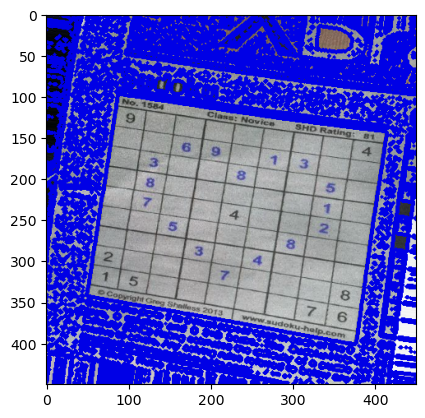

In [5]:
img_1 = img.copy()
contour, hierarchy = cv2.findContours(test,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_1, contour,-1,(0, 0, 230),3)

plt.figure()
plt.imshow(img_1)
plt.show()

References Used: 
https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html
https://pyimagesearch.com/2021/10/06/opencv-contour-approximation/
Douglas-Peucker Algorithm: https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm


In [6]:
#Assumption: sudoku is the largest rectangular contour in given image
def outline(contour):
    dim = np.array([])
    max_area = 0
    for c in contour:
        area = cv2.contourArea(c)
        if area > 100: #100 is arbitrary. May increase value 
            # print("Current Contour's area: ", area)
    
            perimeter = cv2.arcLength(c, True)
            #Approximates a polygonal curve(s) with the specified precision. 
            approx = cv2.approxPolyDP(c, 0.05* perimeter, True)
            #Ignores Non-rectangular Contours
            if area > max_area and len(approx) ==4:
                dim = approx
                max_area = area
    return dim, max_area

def corners(points):
    points = points.reshape((4, 2)) #4 rows, 2 columns
    imgCorners = np.zeros((4,1,2),dtype = np.int32)
    
    #Adds X, Y coordinates together to determine each corners' distance from 0
    add = points.sum(1)
    imgCorners[0] = points[np.argmin(add)] #Determining Corner closest to (0,0)
    imgCorners[3] = points[np.argmax(add)] #Determining Corner furthest from (0,0)

    diff = np.diff(points, axis =1)
    imgCorners[1] = points[np.argmin(diff)] #Positive Diff = Upper Right Corner
    imgCorners[2] = points[np.argmax(diff)] #Negative Diff = Bottom Left Corner
    return imgCorners
    

8


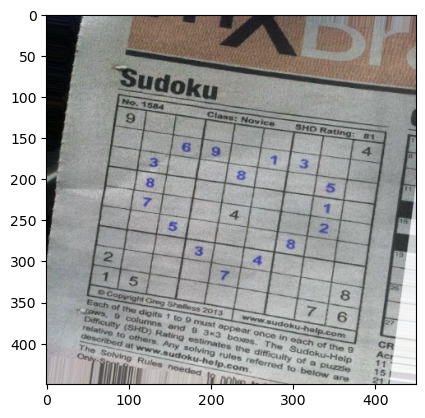

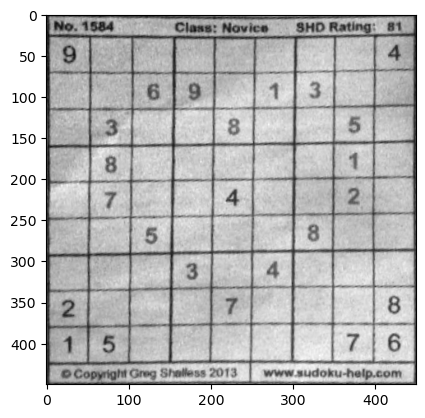

In [7]:
def adjusted_img(contour_img, main_img):
    
    #blank_img = np.zeros((450,450,3), np.uint16)
    points, maxArea = outline(contour_img)
    print(points.size)
    if points.size == 8:
        points = corners(points)
        cv2.drawContours(main_img.copy(), points, -1,(0, 0, 230),10)
        temp1 = np.float32(points)
        temp2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
        matrix = cv2.getPerspectiveTransform(temp1,temp2)  
        imagewrap = cv2.warpPerspective(main_img,matrix,(450,450))
        imagewrap = cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)

        #imagewrap = cv2.adaptiveThreshold(imagewrap,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,29,2)
        
        return imagewrap

result = adjusted_img(contour, img)

plt.imshow(img)
plt.figure()
plt.imshow(result, cmap="gray")
plt.show()


###  Compiling Metholodgy 

Organizing the previous section's steps into a main function to determine the Sudoku Puzzle's location then cropping it into a 450x450 img

After the image is cropped, it is divided into 81 cells where an existing number should reside in.

In [9]:
#requires implementation of accessing File System and selecting an image
#Frontend will handle this aspect and send image through an API

#box_detect(image_input)
def box_detect():
    file = r"C:\Users\atcut\Documents\ML_Proj\Digit Classification\puzzles\_0_926439.jpeg"
    # file = r"C:\Users\atcut\Documents\ML_Proj\Digit Classification\puzzles"
    # file = file + '\\' +random.choice(os.listdir(file))

    # if (file.lower().endswith(('.png', '.jpg', '.jpeg')) is False):
    #     raise Exception("Incompatiable File Type.") 
    img = cv2.imread(file)
    img, test = prep(img)

    img_1 = img.copy()
    contour, hierarchy = cv2.findContours(test,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img_1, contour,-1,(0, 0, 230),3)
    
    result = adjusted_img(contour, img)
    # plt.imshow(img)
    # plt.figure()
    # plt.imshow(result, cmap="gray")
    # plt.show()
    return result
    

### Cell Division

Dividing the Image into list of 81 cells that should contain either a numbered cell or blank 

In [10]:
#Break up grid into 9x9 
#Predict each cell's number & and threshold is above 70% to accept it otherwise default 0
#returns a matrix 
def cell_division(image):
    rows = np.vsplit(image, 9)
    matrix = []
    for i in rows:
        cells = np.hsplit(i, 9)
        for j in cells:
            matrix.append(j)
        
    return matrix

### Testing Section

Sharpening the Image appears to improves the prediction. However, it struggles with images that are grainy, so may need to adjust dataset to involve images of numbers from papers rather than computer generated ones.

In [11]:
cropped_img = box_detect()

8


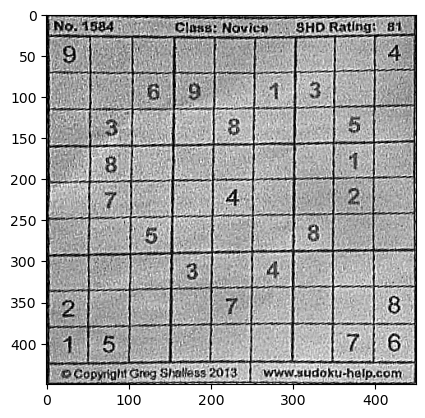

In [12]:
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
cropped_img_test = cv2.filter2D(cropped_img, -1, sharpen_kernel)
grid = cell_division(cropped_img)

plt.imshow(cropped_img_test, cmap="gray")
plt.show()

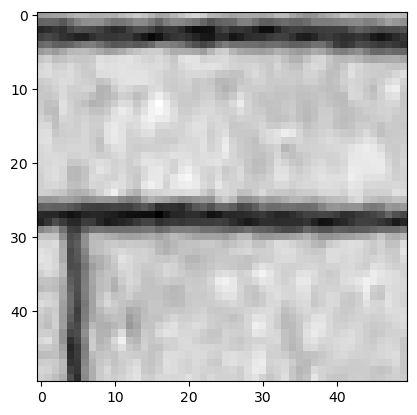

In [19]:
XOX = grid[2]
plt.imshow(XOX, cmap="gray")
plt.show()

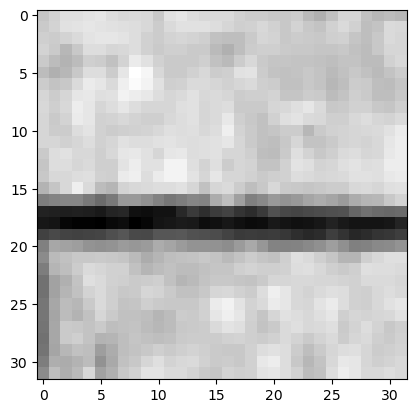

In [20]:
sample = np.asarray(XOX)
sample = sample[6:sample.shape[0] - 6, 6:sample.shape[1] -6]
sample = cv2.resize(sample, (32, 32))
sample = sample / 255

thing = sample.reshape(32, 32, 1)

sample = sample.reshape(1, 32, 32, 1)

plt.imshow(thing, cmap="gray")
plt.show()


In [21]:
#Access the ML model trained to classify digits
rmodel = keras.models.load_model("tf_digit_classifier.keras")

predictions = rmodel.predict(sample)
print(type(predictions))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
<class 'numpy.ndarray'>
[4.4393854e-04 1.1334141e-02 7.0945434e-03 3.6422975e-02 8.5901684e-01
 3.2788236e-02 3.2773022e-02 2.5789877e-03 9.9856984e-03 7.5615868e-03]


In [18]:
# rmodel = keras.models.load_model("tf_digit_classifier.keras")

def sudoku_predict(grid):
    assert isinstance(grid, list), "Input must be a list"

    if len(grid) != 81:
        raise Exception("List does not have 81 cells. Missing Data")

    pre_grid = []
    for c in grid:
        cell = np.asarray(c)
        cell = cell[7:cell.shape[0] - 7, 7:cell.shape[1] -7]
        cell = cv2.resize(cell, (32, 32))
        cell = cell / 255        
        cell = cell.reshape(1, 32, 32, 1)

        predictions = rmodel.predict(cell)
        if np.max(predictions) >= 0.7:
            pre_grid.append(np.argmax(predictions))
        else:
            pre_grid.append(0)

    return pre_grid

puzzle_sample = sudoku_predict(grid)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━

In [16]:
res_matrix =[]

for i in range(9):
    res_matrix.append(puzzle_sample[i*9:(i+1)*9])
print(res_matrix)

[[8, 0, 0, 0, 0, 0, 0, 0, 9], [0, 5, 0, 8, 0, 7, 0, 1, 0], [0, 0, 4, 0, 9, 0, 7, 0, 0], [0, 6, 0, 7, 0, 1, 0, 2, 0], [5, 0, 8, 0, 6, 0, 1, 0, 7], [0, 1, 0, 5, 0, 2, 0, 9, 0], [0, 0, 7, 0, 4, 0, 6, 0, 0], [0, 8, 0, 3, 0, 9, 0, 4, 0], [3, 0, 0, 0, 5, 0, 0, 0, 8]]


# Notes

### Result Consistency

General overview is that images where the sudoku puzzle is too tiny, the numbers are prone to bad/low prediction outcomes that does not satisfy the threshold. Additionally, image quality especially when blur is prevalent impacts the prediction too.

Ideal setting: clear focused image without any obstructions covering the puzzle.

### Exploration into Sharpening Images before Predicting

Was originally having issues with prediction outcomes being abnormally low, but I have no idea what fixed it...

## Main Function

In [17]:
# def main(input):
#     if (input.lower().endswith(('.png', '.jpg', '.jpeg')) is False):
#         raise Exception("Incompatiable File Type.") 
        
#     input_crop = box_detect() #need to include the file system input but not compatible with Jupiter Notebook

#     sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#     cropped_img_test = cv2.filter2D(input_crop, -1, sharpen_kernel)
#     cells = cell_division(input_crop)
    
#     output = sudoku_predict(cells)
    
#     return output
